In [1]:
import sys
sys.path.append("..")

from models.nn_models import *
from models.datasets import TreePartNetOriginalDataset
from data.utils import distinct_colors

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [25]:
treepartnet = TreePartNet.load_from_checkpoint("/space/ariyanzarei/sorghum_segmentation/models/other_datasets_model_checkpoints/TPN/TreePartNet/lightning_logs/version_0/checkpoints/epoch=9-step=8809.ckpt")
treepartnet = treepartnet.cuda()

sorghumpartnet = SorghumPartNetInstance.load_from_checkpoint("/space/ariyanzarei/sorghum_segmentation/models/other_datasets_model_checkpoints/TPN/SorghumPartNetInstance/lightning_logs/version_0/checkpoints/epoch=9-step=4409.ckpt")
sorghumpartnet = sorghumpartnet.cuda()

In [26]:
dataset = TreePartNetOriginalDataset("/space/ariyanzarei/sorghum_segmentation/dataset/TreePartNetData/tree_labeled_val.hdf5")

In [27]:
ind = 68

In [38]:
def TreePartNetPrediction(dataset, ind, merge_similar_clusters=False, merge_threshold=0.5):
    points, _, affinity_matrix = dataset[ind]
    points = points.unsqueeze(0).cuda()
    tpn_preds = treepartnet(points)
    
    pred_cluster = tpn_preds[0]
    pred_aff = tpn_preds[1].squeeze()
    pred_samples_idx = tpn_preds[2].squeeze()
    pred_cluster = torch.argmax(pred_cluster,1).squeeze()

    if not merge_similar_clusters:
        return pred_cluster.cpu()
        
    pred_aff = (pred_aff>=merge_threshold).int().squeeze()
    pred_final_cluster = pred_cluster.cpu()

    for i in range(256):
        for j, v in enumerate(pred_aff[i]):
            if v == 1:
                pred_final_cluster[pred_final_cluster == pred_final_cluster[pred_samples_idx[j]]] = pred_final_cluster[pred_samples_idx[i]]
    
    return pred_final_cluster


def SorghumPartNetPredictions(dataset, ind):
    points, _, _ = dataset[ind]
    points = points.unsqueeze(0).cuda()
    spn_preds = sorghumpartnet(points.double())
    spn_preds_cpu = spn_preds.cpu().detach().numpy().squeeze()
    clustering = DBSCAN(eps=1.58, min_samples=3).fit(spn_preds_cpu)
    pred_cluster = clustering.labels_
    return torch.from_numpy(pred_cluster)
    
def calculate_metrics(predictions, ground_truth):
    metric_calc = LeafMetrics("cpu")
    result_metrics = metric_calc(predictions, ground_truth)
    return result_metrics

In [39]:

tpn_no_merge_predictions = TreePartNetPrediction(dataset, ind,False)
tpn_merge_predictions = TreePartNetPrediction(dataset, ind,True)
spn_predictions = SorghumPartNetPredictions(dataset, ind)

cluster_label  = dataset[ind][1]
cluster_label = cluster_label.unsqueeze(0).unsqueeze(-1)
tpn_no_merge_predictions = tpn_no_merge_predictions.unsqueeze(0).unsqueeze(-1)
tpn_merge_predictions = tpn_merge_predictions.unsqueeze(0).unsqueeze(-1)
spn_predictions = spn_predictions.unsqueeze(0).unsqueeze(-1)

res_tpn_no_merge = calculate_metrics(tpn_no_merge_predictions, cluster_label)
res_tpn_merge = calculate_metrics(tpn_merge_predictions, cluster_label)
res_spn = calculate_metrics(spn_predictions, cluster_label)


print(res_tpn_no_merge)
print(res_tpn_merge)
print(res_spn)

(0.8155593872070312, 0.20447416603565216, 0.6150636672973633, 0.3069159686565399)
(0.8155593872070312, 0.20447416603565216, 0.6150636672973633, 0.3069159686565399)
(0.9521557688713074, 0.6956644058227539, 0.49670231342315674, 0.5795836448669434)


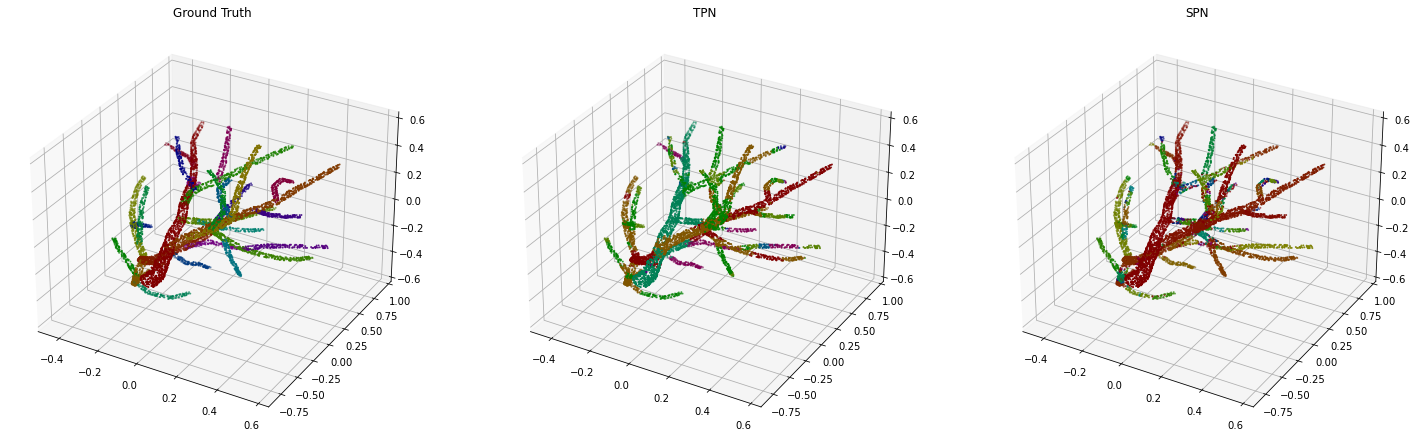

In [42]:
points = dataset[ind][0]
labels_gt = cluster_label.squeeze().cpu()
labels_tpn = tpn_merge_predictions.squeeze().cpu()
labels_spn = spn_predictions.squeeze().cpu()

d_colors = distinct_colors(len(set(labels_gt.tolist())))
colors_gt = np.zeros((labels_gt.shape[0], 3))
for i, l in enumerate(list(set(labels_gt.tolist()))):
    colors_gt[labels_gt == l, :] = d_colors[i]

d_colors = distinct_colors(len(set(labels_tpn.tolist())))
colors_tpn = np.zeros((labels_tpn.shape[0], 3))
for i, l in enumerate(list(set(labels_tpn.tolist()))):
    colors_tpn[labels_tpn == l, :] = d_colors[i]

d_colors = distinct_colors(len(set(labels_spn.tolist())))
colors_spn = np.zeros((labels_spn.shape[0], 3))
for i, l in enumerate(list(set(labels_spn.tolist()))):
    colors_spn[labels_spn == l, :] = d_colors[i]

fig = plt.figure(figsize=(25,25))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(points[:,0],points[:,1],points[:,2], s=1, c=colors_gt)
ax1.set_title("Ground Truth")

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(points[:,0],points[:,1],points[:,2], s=1, c=colors_tpn)
ax2.set_title("TPN")

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(points[:,0],points[:,1],points[:,2], s=1, c=colors_spn)
ax3.set_title("SPN")

plt.show()